# Parsing and Recombining Inputs

In this chapter, we use grammars to parse and decompose inputs, allowing us to recombine them arbitrarily.
\todo{Work in progress.}
* Specify the restrictions due to precedence
* Specify the class of languages covered (what is the overlap with CFG)
* Specify the restrictions on our implementation (parsing predicates)

**Prerequisites**

* You should have read the [chapter on grammars](Grammars.ipynb).

In [37]:
import fuzzingbook_utils

In [38]:
from Grammars import EXPR_GRAMMAR, START_SYMBOL

In [39]:
from GrammarFuzzer import display_tree

In [40]:
import functools
import re

RE_NONTERMINAL = re.compile(r'(<[a-zA-Z_]*>)')

In [41]:
class PEGParser:
    def __init__(self, grammar):
        def split(rule): return tuple(
            s for s in re.split(
                RE_NONTERMINAL, rule) if s)
        self.grammar = {k: [split(l) for l in rules]
                        for k, rules in grammar.items()}

    def literal_match(self, part, text, cursor):
        return (cursor + len(part), (part, [])
                ) if text[cursor:].startswith(part) else (cursor, None)

    # memoize repeated calls.
    @functools.lru_cache(maxsize=None)
    def unify_key(self, key, text, cursor=0):
        rules = self.grammar[key]
        # make a generator for matching rules. We dont want a list because
        # we want to be lazy and evaluate only until the first matching
        rets = (self.unify_line(rule, text, cursor) for rule in rules)
        # return the first non null (matching) rule's cursor and res
        cursor, res = next(
            (ret for ret in rets if ret[1] is not None), (cursor, None))
        return (cursor, (key, res) if res is not None else None)

    def unify_line(self, parts, text, cursor):
        def is_symbol(v): return v[0] == '<'

        results = []
        for part in parts:
            # get the matcher function
            matcher = (self.unify_key if is_symbol(
                part) else self.literal_match)
            # compute the cursor, and the result from it.
            cursor, res = matcher(part, text, cursor)
            if res is None:
                return (cursor, None)
            results.append(res)
        return cursor, results

In [42]:
def parse(text, grammar, start_symbol=START_SYMBOL):
    def readall(fn): return ''.join([f for f in open(fn, 'r')]).strip()

    result = PEGParser(grammar).unify_key(start_symbol, text)
    return result

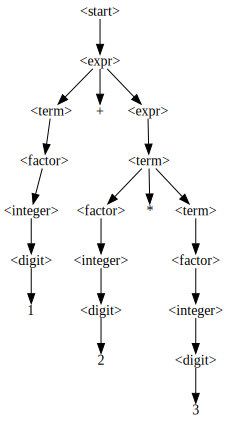

In [43]:
cursor, tree = parse("1 + 2 * 3", EXPR_GRAMMAR)
display_tree(tree)

## Table driven parsers

Parsing Expression Grammars specifically oriented towards writing recognizers. Unfortunately, Parsing Expression Grammars are not suitable for grammar based fuzzing. \todo{Verify, and explain how precedence in parsing is not translatable to generation}.
\todo{Explain LL(k), LR(k), and general Context-Free parsers such as Early and CYK parsers}


### LL(1) parser

LL(k) parsers are top-down parsers that rely on a lookahead of k tokens. We provide an implementation of an LL(1) parser.

We first need a few tools to massage the grammar. The `split_tokens` splits a production rule to its constituent tokens.

In [60]:
def split_tokens(rule):
    return [i for i in re.split(RE_NONTERMINAL, rule) if i != ''] or ['']

LL(1) grammars are rather restrictive. Specifically, the grammar should not contain left recursion. Hence, we have to
update our original grammar to remove left-recursion.

In [61]:
grammar = {'<start>': ['<expr>'],
           '<expr>': ['<term><expr_>'],
           '<expr_>': ['+<expr>',
                       '-<expr>',
                       ''],
           '<term>': ['<factor><term_>'],
           '<term_>': ['*<term>',
                       '/<term>',
                       ''],
           '<factor>': ['+<factor>',
                        '-<factor>',
                        '(<expr>)',
                        '<int>'],
           '<int>': ['<integer><integer_>'],
           '<integer_>': ['',
                          '.<integer>'],
           '<integer>': ['<digit><I>'],
           '<I>': ['<integer>',
                   ''],
           '<digit>': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']}

Next, we need to change the grammar so that the productions become tokens

In [62]:
new_grammar = {k: [split_tokens(e) for e in grammar[k]] for k in grammar}
new_grammar

{'<start>': [['<expr>']],
 '<expr>': [['<term>', '<expr_>']],
 '<expr_>': [['+', '<expr>'], ['-', '<expr>'], ['']],
 '<term>': [['<factor>', '<term_>']],
 '<term_>': [['*', '<term>'], ['/', '<term>'], ['']],
 '<factor>': [['+', '<factor>'],
  ['-', '<factor>'],
  ['(', '<expr>', ')'],
  ['<int>']],
 '<int>': [['<integer>', '<integer_>']],
 '<integer_>': [[''], ['.', '<integer>']],
 '<integer>': [['<digit>', '<I>']],
 '<I>': [['<integer>'], ['']],
 '<digit>': [['0'],
  ['1'],
  ['2'],
  ['3'],
  ['4'],
  ['5'],
  ['6'],
  ['7'],
  ['8'],
  ['9']]}

We also need to get the listing of production rules, and the set of terminals in the grammar

In [63]:
def rules(g): return [(k, e) for k, a in g.items() for e in a]

In [64]:
def terminals(g):
    return set(token for k, expr in rules(g)
               for token in expr if token not in g)

### First and Follow sets

\todo{Define first and follow sets}
We first define the fixpiont
\todo{Define what is a fixpoint of a function}

In [65]:
def fixpoint(f):
    def helper(*args):
        while True:
            sargs = repr(args)
            args_ = f(*args)
            if repr(args_) == sargs:
                return args
            args = args_
    return helper

In [66]:
@fixpoint
def compute_ff(grammar, first, follow, epsilon):
    for A, expression in rules(grammar):
        nullable = True
        for token in expression:
            first[A] |= first[token]

            # update until the first token that is not nullable
            if token not in epsilon:
                nullable = False
                break

        if nullable:
            epsilon |= {A}
            first[A] |= {''}

        # https://www.cs.uaf.edu/~cs331/notes/FirstFollow.pdf
        # essentially, we start from the end of the expression. Then:
        # (3) if there is a production A -> aB, then every thing in
        # FOLLOW(A) is in FOLLOW(B)
        follow_B = follow[A]
        for t in reversed(expression):
            if not t:
                continue
            # update the follow for the current token. If this is the
            # first iteration, then here is the assignment
            if t in grammar:
                follow[t] |= follow_B  # only bother with nt

            # computing the last follow symbols for each token t. This
            # will be used in the next iteration. If current token is
            # nullable, then previous follows can be a legal follow for
            # next. Else, only the first of current token is legal follow
            # essentially

            # (2) if there is a production A -> aBb then everything in FIRST(B)
            # except for epsilon is added to FOLLOW(B)
            follow_B = follow_B | (
                first[t] - {''}) if t in epsilon else first[t]

    return (grammar, first, follow, epsilon)

In [67]:
def process(grammar):
    # Initialize first and follow sets for non-terminals
    first = {i: set() for i in grammar}
    follow = {i: set() for i in grammar}

    # If X is a terminal, then First(X) is just X
    first.update((i, {i}) for i in terminals(grammar))
    epsilon = {''}
    return compute_ff(grammar, first, follow, epsilon)

In [68]:
def rnullable(rule, epsilon):
    return all(token in epsilon for token in rule)

In [69]:
def rfirst(rule, first, epsilon):
    tokens = set()
    for token in rule:
        tokens |= first[token]
        if token not in epsilon:
            break  # not nullable
    return tokens

In [70]:
def predict(rulepair, first, follow, epsilon):
    A, rule = rulepair
    rf = rfirst(rule, first, epsilon)
    if rnullable(rule, epsilon):
        rf |= follow[A] - {''}
    return rf

In [71]:
def parse_table(grammar, my_rules):
    _, first, follow, epsilon = process(grammar)

    ptable = [(rule, predict(rule, first, follow, epsilon))
              for rule in my_rules]

    parse_tbl = {k: {} for k in grammar}

    for (k, expr), pvals in ptable:
        parse_tbl[k].update({v: (k, expr) for v in pvals})
    return parse_tbl

In [72]:
def parse_helper(grammar, tbl, stack, inplst):
    inp, *inplst = inplst
    exprs = []
    while stack:
        val, *stack = stack
        if isinstance(val, tuple):
            exprs.append(val)
            continue
        if val not in grammar:  # terminal
            if val == '':
                exprs.append(val)
                continue
            if val != inp:
                raise Exception("%s != %s" % (val, inp))
            exprs.append(val)
            inp, *inplst = [*inplst, '']
        else:
            k, rhs = tbl[val][inp]
            assert k == val
            stack = rhs + [(val, len(rhs))] + stack
    return exprs

In [73]:
def parse(grammar, inp):
    my_rules = rules(grammar)
    parse_tbl = parse_table(grammar, my_rules)
    k, _ = my_rules[0]
    stack = [k]
    return parse_helper(grammar, parse_tbl, stack, list(inp))

In [74]:
def linear_to_tree(arr):
    stack = []
    while arr:
        elt = arr.pop(0)
        if not isinstance(elt, tuple):
            stack.append((elt, []))
        else:
            # get the last n
            sym, n = elt
            elts = stack[-n:]
            stack = stack[0:len(stack) - n]
            stack.append((sym, elts))
    assert len(stack) == 1
    return stack[0]

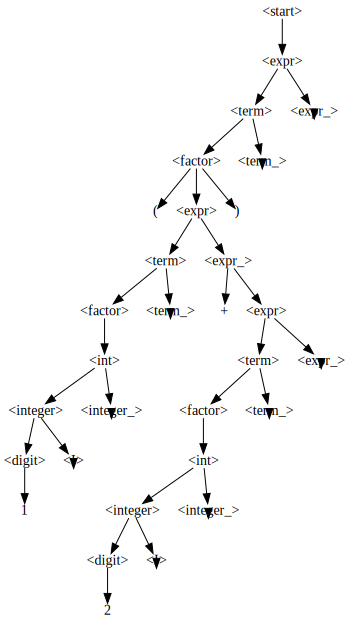

In [75]:
tree = linear_to_tree(parse(new_grammar, '(1+2)'))
display_tree(tree)

### Earley parser

In [76]:
def epsilon_convert(rule): return [i for i in rule if i != '']

class State(object):
    def __init__(self, name, expr, dot, origin, children=[]):
        self.name, self.expr, self.dot, self.origin = name, expr, dot, origin
        self.children = children[:]
    def finished(self): return self.dot >= len(self.expr)
    def shift(self):
        return State(self.name, self.expr, self.dot+1, self.origin, self.children)
    def symbol(self): return self.expr[self.dot]

    def _t(self): return (self.name, self.expr, self.dot, self.origin)
    def __hash__(self): return hash((self.name, self.expr))
    def __eq__(self, other): return  self._t() == other._t()

class Column(object):
    def __init__(self, token):
        self.token, self.states, self._unique = token, [], {}

    def add(self, state):
        if state in self._unique: return self._unique[state]
        self._unique[state] = state
        self.states.append(state)
        return self._unique[state]

def predict(col, sym, grammar):
    for alt in grammar[sym]:
        col.add(State(sym, tuple(alt), 0, col))

def scan(col, state, token):
    if token == col.token:
        col.add(state.shift())

def complete(col, state, grammar):
    for st in state.origin.states:
        if st.finished(): continue
        if state.name != st.symbol(): continue
        col.add(st.shift()).children.append(state)

# http://courses.washington.edu/ling571/ling571_fall_2010/slides/parsing_earley.pdf
# https://github.com/tomerfiliba/tau/blob/master/earley3.py
def parse(words, grammar, start):
    alt = tuple(*grammar[start])
    chart = [Column(tok) for tok in [None, *words]]
    chart[0].add(State(start, alt, 0, chart[0], []))

    for i, col in enumerate(chart):
        for state in col.states:
            if state.finished():
                complete(col, state, grammar)
            else:
                sym = state.symbol()
                if sym in grammar:
                    predict(col, sym, grammar)
                else:
                    if i + 1 >= len(chart): continue
                    scan(chart[i+1], state, sym)
    return chart

In [77]:
def process_expr(expr, children, grammar):
    terms = iter([(i,[]) for i in expr if i not in grammar])
    nts = iter([node_translator(i, grammar) for i in  children])
    return [next(terms if i not in grammar else nts) for i in expr]

def node_translator(state, grammar):
    return (state.name, process_expr(state.expr, state.children, grammar))

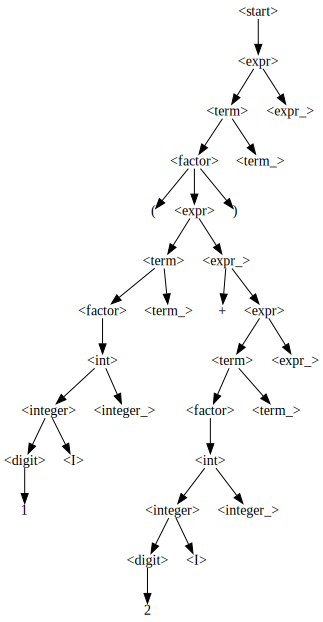

In [84]:
new_grammar = {k: [epsilon_convert(split_tokens(e)) for e in grammar[k]] for k in grammar}
table = parse(list('(1+2)'), new_grammar, '<start>')
state, *states = [st for st in table[-1].states if st.name == '<start>' and st.finished()]
display_tree(node_translator(state, new_grammar))

## Lessons Learned

* _Lesson one_
* _Lesson two_
* _Lesson three_

## Next Steps

_Link to subsequent chapters (notebooks) here, as in:_

* [use _mutations_ on existing inputs to get more valid inputs](MutationFuzzer.ipynb)
* [use _grammars_ (i.e., a specification of the input format) to get even more valid inputs](Grammars.ipynb)
* [reduce _failing inputs_ for efficient debugging](Reducing.ipynb)


## Exercises

Close the chapter with a few exercises such that people have things to do.  In Jupyter Notebook, use the `exercise2` nbextension to add solutions that can be interactively viewed or hidden:

* Mark the _last_ cell of the exercise (this should be a _text_ cell) as well as _all_ cells of the solution.  (Use the `rubberband` nbextension and use Shift+Drag to mark multiple cells.)
* Click on the `solution` button at the top.

(Alternatively, just copy the exercise and solution cells below with their metadata.)

### Exercise 1

_Text of the exercise_

In [ ]:
# Some code that is part of the exercise
pass

_Some more text for the exercise_

_Some text for the solution_

In [ ]:
# Some code for the solution
2 + 2

_Some more text for the solution_

### Exercise 2

_Text of the exercise_

_Solution for the exercise_